這個 colab 示範 Gemini 的多模態功能

使用 Gemini 新的 Python SDK https://github.com/googleapis/python-genai


In [ ]:
# from google.colab import userdata
# gemini_api_key = userdata.get('gemini_api_key')

In [1]:
!pip install google-genai

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
instructor 1.7.2 requires tenacity<10.0.0,>=9.0.0, but you have tenacity 8.5.0 which is incompatible.
litellm 1.60.2 requires httpx<0.28.0,>=0.23.0, but you have httpx 0.28.1 which is incompatible.
polygon-api-client 1.14.2 requires websockets<13.0,>=10.3, but you have websockets 15.0.1 which is incompatible.
streamlit 1.26.0 requires pillow<10,>=7.1.0, but you have pillow 11.1.0 which is incompatible.
weaviate-client 4.7.1 requires httpx<=0.27.0,>=0.25.0, but you have httpx 0.28.1 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached anyio-4.9.0-py3-none-any.whl.metadata (4.7 kB)
  Using cached websockets-15.0.1-cp311-cp311-win_amd64.whl.metadata (7.0 kB)
Using cached anyio-4.9.0-py3-none-any.whl (100 kB)
Using cached websockets-15.0.1-cp311-cp311-win_amd64.whl (176 kB)
  Attempting uninstall: websockets
    Found existing installation: websockets 12.0
    Uninstalling websockets-12.0:
      Successfully uninstalled websockets-12.0
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
  Attempting uninstall: anyio
    Found existing installation: anyio 3.7.1
    Uninstalling anyio-3.7.1:
      Successfully uninstalled anyio-3.7.1
  Attempting uninstall: httpx
    Found existing installation: httpx 0.27.0
    Uninstalling httpx-0.27.0:
      Successfully uninstalled httpx-0.27.0


In [3]:
# Import necessary libraries
## 設定 OpenAI API Key 變數
from dotenv import load_dotenv
import os

# Load the environment variables from .env file
load_dotenv()

# Access the API key
gemini_api_key = os.getenv('gemini_api_key')


In [4]:
from google import genai
from google.genai import types

client = genai.Client(api_key=gemini_api_key)

## 圖片解讀

https://ai.google.dev/gemini-api/docs/vision?hl=zh-tw&lang=python

In [ ]:
import requests

# image_path = "https://ihower.tw/data/images/wireframe.jpg"
# image = requests.get(image_path)

image_path = "https://www.books.com.tw/csss/private/qa/images/step_ShoppingProcess/ShoppingProcess_01.jpg"
image = requests.get(image_path)


<Response [200]>

In [11]:
response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=["這什麼圖片?",
              types.Part.from_bytes(data=image.content, mime_type="image/jpeg")])

print(response.text)

The image is a login form for a website. It includes fields for member ID, password, and a CAPTCHA (verification code).



## 圖片生成

2025/3/12 最新功能: https://developers.googleblog.com/en/experiment-with-gemini-20-flash-native-image-generation/

https://ai.google.dev/gemini-api/docs/image-generation?hl=zh-tw

In [12]:
from PIL import Image
from io import BytesIO
import base64

contents = ('''Hi, can you create a 3d rendered image of a vulture
with a cane and a top hat flying over a happy
futuristic scifi city with lots of greenery, and a tiger looking up from below?''')

response = client.models.generate_content(
    model="gemini-2.0-flash-exp-image-generation",
    contents=contents,
    config=types.GenerateContentConfig(
      response_modalities=['Text', 'Image']
    )
)

for part in response.candidates[0].content.parts:
  if part.text is not None:
    print(part.text)
  elif part.inline_data is not None:
    image2 = Image.open(BytesIO((part.inline_data.data)))
    image2.save('gemini-native-image.png')
    image2.show()

I'll create a 3D rendered image of a distinguished vulture, wearing a grey top hat and leaning on a wooden cane, soaring gracefully through the air. Below, a vibrant, futuristic sci-fi city will be depicted with sleek, modern buildings interwoven with lush green vegetation, creating a harmonious blend of nature and technology. On the ground, a Bengal tiger will be looking upwards at the flying vulture with a curious expression. 



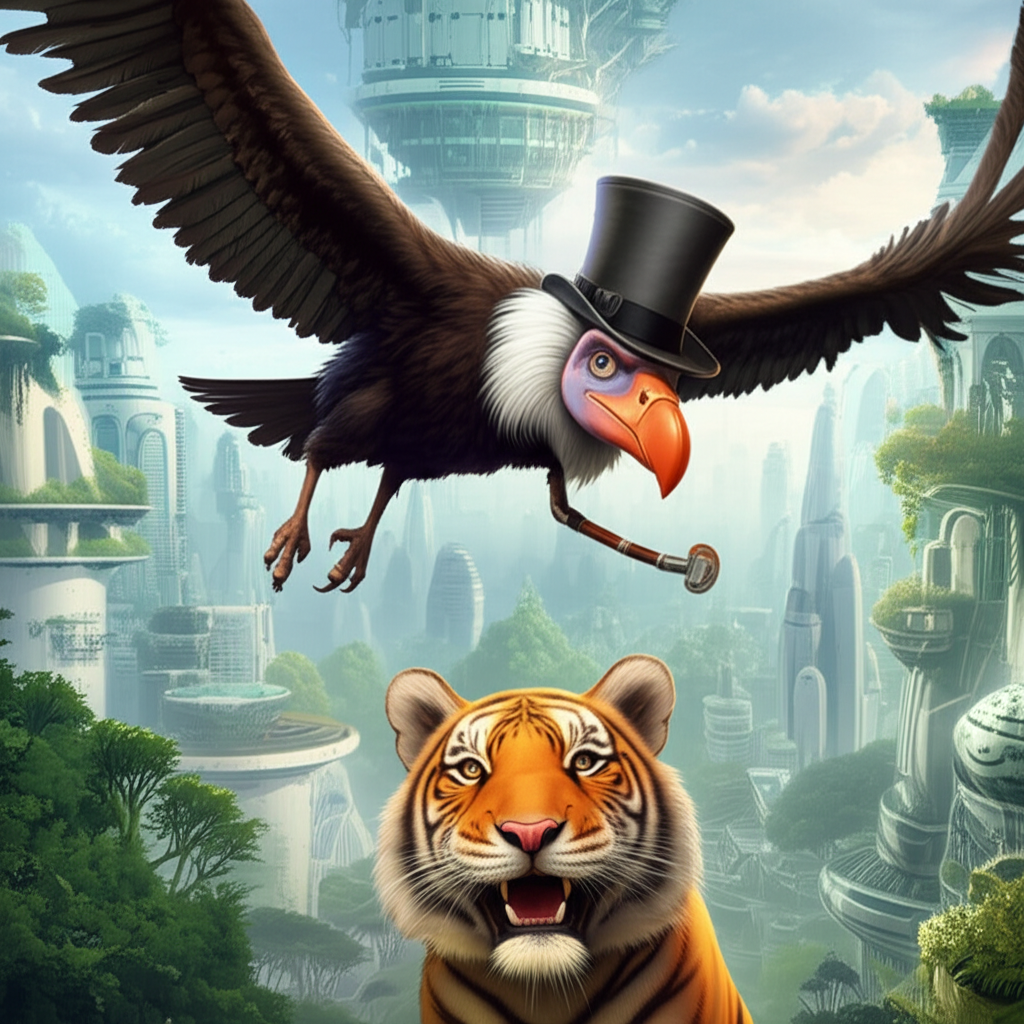

In [13]:
image2

In [14]:
from PIL import Image
from io import BytesIO
import base64

response = client.models.generate_content(
    model="gemini-2.0-flash-exp-image-generation",
    contents=["請基於這張圖片產生一張黑白的",
              types.Part.from_bytes(data=image.content, mime_type="image/jpeg")],
    config=types.GenerateContentConfig(
      response_modalities=['Text', 'Image']
    )
)

for part in response.candidates[0].content.parts:
  if part.text is not None:
    print(part.text)
  elif part.inline_data is not None:
    image = Image.open(BytesIO((part.inline_data.data)))
    image.save('gemini-native-image2.png')
    image.show()

好的，我將把這張登入介面圖片轉換成黑白色調。




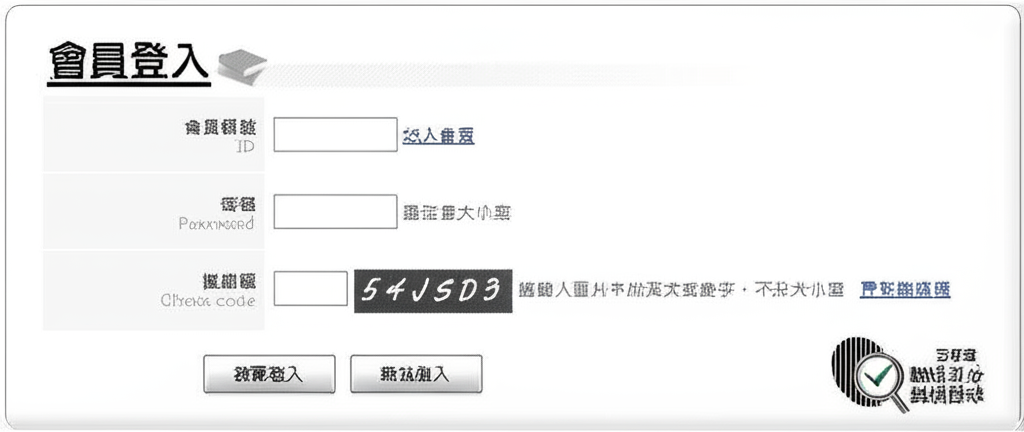

In [15]:
image

## 上傳 PDF (Gemini 內部是逐張轉成圖片解讀)

https://ai.google.dev/gemini-api/docs/document-processing?hl=zh-tw&lang=python

可以一次多個 PDFs 檔案也行

PDF 出處: https://investor.tsmc.com/chinese/quarterly-results/2024/q4

In [21]:
# !wget https://ihower.tw/data/tsmc-2024-q4.pdf

import urllib.request

url = "https://mopsov.twse.com.tw/nas/STR/352920250212M001.pdf"
filename = "2024第四季法人財報_ememory.pdf"  # 可自訂檔名與副檔名

try:
    urllib.request.urlretrieve(url, filename)
    print(f"檔案已下載並儲存為 {filename}")
except Exception as e:
    print("下載失敗，錯誤訊息：", e)

檔案已下載並儲存為 2024第四季法人財報_ememory.pdf


In [22]:
file = client.files.upload(file='2024第四季法人財報_ememory.pdf')

In [23]:
response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=['請問根據平台 2024 年整年的銷售比例?', file]
)
print(response.text)

根據平台2024年整年的銷售比例顯示在第7和第8頁的圖表裡面。其中：
*   **總營收 (Total Revenue)**:
    *   NeoBit: 25.2%
    *   NeoFuse: 61.3%
    *   PUF-Based: 4.5%
    *   MTP: 9.0%
*   **授權金營收 (Licensing Revenue)**:
    *   NeoBit: 24.5%
    *   NeoFuse: 37.9%
    *   PUF-Based: 14.3%
    *   MTP: 23.3%
*   **權利金營收 (Royalty Revenue)**:
    *   NeoBit: 25.5%
    *   NeoFuse: 72.1%
    *   PUF-Based: 0.0%
    *   MTP: 2.4%


## 結合 Gemini 的 structured output 功能: 讓我們直接轉出結構化數據

https://ai.google.dev/gemini-api/docs/structured-output?lang=python

In [24]:
import json
from pydantic import BaseModel

class FinancialReport(BaseModel):
    quarter: str  # 4Q24
    revenue_usd_billion: float  # 營業收入淨額(美金十億元)
    revenue_twd: float  # 營業收入淨額
    gross_margin_percentage: float  # 營業毛利率
    operating_expenses: float  # 營業費用
    operating_margin_percentage: float  # 營業淨利率
    non_operating_income: float  # 營業外收入及支出
    net_income_attributable_to_parent: float  # 歸屬予母公司業主之本期淨利
    net_profit_margin_percentage: float  # 純益率
    earnings_per_share_twd: float  # 每股盈餘(新台幣元)
    return_on_equity_percentage: float  # 股東權益報酬率
    wafer_shipments_thousand_pieces: int  # 晶圓出貨量(千片十二吋約當晶圓)
    average_exchange_rate_usd_twd: float  # 平均匯率(美元/新台幣)


response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=['請截取出 2024 Q4 的財報數據', file],
    config=types.GenerateContentConfig(
        response_mime_type='application/json',
        response_schema=FinancialReport,
    ),
)
print(response.text)

{
  "quarter": "Q4 2024",
  "revenue_usd_billion": 0.0317,
  "revenue_twd": 1010717000.0,
  "gross_margin_percentage": 1.0,
  "operating_expenses": 444784000.0,
  "operating_margin_percentage": 0.56,
  "non_operating_income": 0.0,
  "net_income_attributable_to_parent": 514608000.0,
  "net_profit_margin_percentage": 0.511,
  "earnings_per_share_twd": 6.89,
  "return_on_equity_percentage": 0.625,
  "wafer_shipments_thousand_pieces": 0,
  "average_exchange_rate_usd_twd": 31.88
}


In [25]:
json.loads(response.text)

{'quarter': 'Q4 2024',
 'revenue_usd_billion': 0.0317,
 'revenue_twd': 1010717000.0,
 'gross_margin_percentage': 1.0,
 'operating_expenses': 444784000.0,
 'operating_margin_percentage': 0.56,
 'non_operating_income': 0.0,
 'net_income_attributable_to_parent': 514608000.0,
 'net_profit_margin_percentage': 0.511,
 'earnings_per_share_twd': 6.89,
 'return_on_equity_percentage': 0.625,
 'wafer_shipments_thousand_pieces': 0,
 'average_exchange_rate_usd_twd': 31.88}

## 影片

https://ai.google.dev/gemini-api/docs/vision?hl=zh-tw&lang=python#prompting-video

可以上傳影片、也可以直接吃 youtube 連結

example: https://x.com/_philschmid/status/1905566076781371642/photo/1

In [26]:
youtube_url = "https://www.youtube.com/watch?v=kOZWQgtqps4"

In [27]:
response = client.models.generate_content(
    model='models/gemini-2.0-flash',
    contents=types.Content(
        parts=[
            types.Part(text='Summarize this video. 用繁體中文輸出.'),
            types.Part(
                file_data=types.FileData(file_uri=youtube_url)
            )
        ]
    )
)

In [28]:
print(response.text)

好的，這就為您總結這個影片：

Andy老師，一位YouTube頻道主，在影片中揭露了他經營近十年的頻道「重量級 CROWD」不屬於他的真相，並向粉絲交代了頻道創立的始末。

Andy表示，2016年9月18日他親自註冊了該頻道，之後與他的女朋友嘉寧共同經營，拍攝情侶整人影片，逐漸提高頻道觀看率及訂閱率，也開始接商業植入及業配。由於頻道越來越忙碌，Andy和女友委託嘉寧的母親曾淑惠（簡稱張媽媽）協助處理與廠商之間的金流核對事宜。

2018年，張媽媽以其本有公司群海娛樂股份有限公司管理會計及稅務，並擔任該公司董事長，Andy表示，由於信任張媽媽，加上張媽媽也可能是未來的岳母，他因此將最大的信任全權託付。

但是，陸續發生了一些事讓Andy感到奇怪，像是股份分配中，張媽媽佔50%，女友及他各佔25%，而他對經營公司毫無概念，傻傻的簽下合約。十年來，他只領到每月固定薪資和獎金，也沒辦法查看公司的帳目。他指出，自2018年開始，他每月只領取3萬元的薪水，直到2019年，才加薪為5萬5，這讓他生活十分吃緊。

Andy說明，自2020年開始，他多次向張媽媽提出要看帳目，但都遭到推託，他還委託女友與其母溝通，但無果。在與女友分手後，甚至被斷了金援，而且連購買影片剪輯的電腦都不讓他帶走。

接著，在2024年11月的某天，Andy發現他無法登入頻道及社群平台，他感到十分震驚。這時他發現在2020年4月，張媽媽以個人名義，向經濟部智慧財產局，申請了「重量級」這三個字的商標註冊。

在發布這個影片的當下，Andy表示，這一切讓他終於決定提起勇氣，希望把事情說清楚，要求張媽媽提出帳單，並要追查商標的部分。


## 聲音

https://ai.google.dev/gemini-api/docs/audio?hl=zh-tw&lang=python

example: https://x.com/_philschmid/status/1892168007402578182 可以轉逐字稿


In [31]:
# !wget https://ihower.tw/data/tsmc-2024-q4.pdf

import urllib.request

url = "https://file.cdn.firstory.me/Record/ckkqnneka7mxc0866j53j5ljw/cm792bjge001y01yl1re4coe2.mp3"
filename = "cm792bjge001y01yl1re4coe2.mp3"  # 可自訂檔名與副檔名

try:
    urllib.request.urlretrieve(url, filename)
    print(f"檔案已下載並儲存為 {filename}")
except Exception as e:
    print("下載失敗，錯誤訊息：", e)

檔案已下載並儲存為 cm792bjge001y01yl1re4coe2.mp3


In [32]:
myfile = client.files.upload(file='cm792bjge001y01yl1re4coe2.mp3')

response2 = client.models.generate_content(
  model='gemini-2.0-flash',
  contents=['Generate a transcript of the speech.', myfile]
)

print(response2.text)

还记得在台北市政府的跨年晚会上，放完烟火之后呢，出现的大明星福利熊吗？ 其实呢他不止是要支援收银哦，还要表演给大家看。 那现在许多企业都会打造专属于自己的IP，或者是吉祥物。 这样子的行销手法是真的有效吗？ 今天记者茶水间我们一起来聊聊。 欢迎回来本周的记者茶水间，我是这一周的驻主持人浅浅。 那我们先欢迎数位时代的记者林臻。 哈啰大家好，我是林臻。 好，那林臻之前做了一个就是有关企业IP这件事情的专题嘛。 那我自己觉得这专题有趣，那是我们有两个案例，一个是福利熊，然后一个是高雄捷运的那个猫咪站长蜜柑。 然后我觉得除了非常可爱之外呢，他其实也有背后有很多我们不知道的故事，尤其是福利熊，我觉得那时候跨年的时候，像我们刚刚开头提到，就是跨年，他登上那个台北市政府跨年的舞台嘛。 那大家就会想说，欸就是凭什么就是放完烟火之后，大家都会看到是福利熊，就是大家会有点吓一跳这样。 就可以看得出来全联其实在这个IP上面，我自己觉得是花了很多心思。 然后因为我觉得福利熊这个IP的露出程度是非常的高的。 所以就是也算是家喻户晓，而叟能想这样。 然后今年其实呢，福利熊它也是已经十岁了。 对，他元旦那一天满10岁。 嗯，就是也是满惊讶的，好，那我们先回到这个专题来说好了，那一开始我们怎么会想要做一个类似这样子的专题？ 就是是有看到什么样的情况？ 或是是怎么样，社群现象让你觉得可以做这样子的专题。 对，现在谈到福利熊的话，大家的印象已经就是元旦的那一场表演。 但其实我们专题从发想开始，会有一段的规划时间，所以像这个题目最初其实是注意到去年9月的时候，推上面出现了全联水果探险队这个这个玩偶的开箱影片。 那就让这一组，他其实是一个用纸箱装的，里面有6只全联就是以水果作为形象打造的6只的小狗。 他们是水狗对不对？ 他们是水狗。 就台湾国语梗。 对，就是这个水狗梗。 那这个开箱影片在推上面社群上面红了之后，瞬间我们社群温度就很爆表。 所以就开始去想说，好像可以来讨论一下说，本来用来当作品牌识别的吉祥物，它开始独立能够变现的这件事情。 所以这一个命题的重点会是说，吉祥物已经不是传统，我们纯粹说觉得，是企业想要营造好感加深消费者印象的角色。 它最具代表性的，或许是我们可以想到Line Friends，就是Line推出的这系列角色。 熊大吗？ 熊大、兔兔、莎莉那些。 都爱对。 对对对，那他这系列角色，其实现

In [33]:
response2.text

'还记得在台北市政府的跨年晚会上，放完烟火之后呢，出现的大明星福利熊吗？ 其实呢他不止是要支援收银哦，还要表演给大家看。 那现在许多企业都会打造专属于自己的IP，或者是吉祥物。 这样子的行销手法是真的有效吗？ 今天记者茶水间我们一起来聊聊。 欢迎回来本周的记者茶水间，我是这一周的驻主持人浅浅。 那我们先欢迎数位时代的记者林臻。 哈啰大家好，我是林臻。 好，那林臻之前做了一个就是有关企业IP这件事情的专题嘛。 那我自己觉得这专题有趣，那是我们有两个案例，一个是福利熊，然后一个是高雄捷运的那个猫咪站长蜜柑。 然后我觉得除了非常可爱之外呢，他其实也有背后有很多我们不知道的故事，尤其是福利熊，我觉得那时候跨年的时候，像我们刚刚开头提到，就是跨年，他登上那个台北市政府跨年的舞台嘛。 那大家就会想说，欸就是凭什么就是放完烟火之后，大家都会看到是福利熊，就是大家会有点吓一跳这样。 就可以看得出来全联其实在这个IP上面，我自己觉得是花了很多心思。 然后因为我觉得福利熊这个IP的露出程度是非常的高的。 所以就是也算是家喻户晓，而叟能想这样。 然后今年其实呢，福利熊它也是已经十岁了。 对，他元旦那一天满10岁。 嗯，就是也是满惊讶的，好，那我们先回到这个专题来说好了，那一开始我们怎么会想要做一个类似这样子的专题？ 就是是有看到什么样的情况？ 或是是怎么样，社群现象让你觉得可以做这样子的专题。 对，现在谈到福利熊的话，大家的印象已经就是元旦的那一场表演。 但其实我们专题从发想开始，会有一段的规划时间，所以像这个题目最初其实是注意到去年9月的时候，推上面出现了全联水果探险队这个这个玩偶的开箱影片。 那就让这一组，他其实是一个用纸箱装的，里面有6只全联就是以水果作为形象打造的6只的小狗。 他们是水狗对不对？ 他们是水狗。 就台湾国语梗。 对，就是这个水狗梗。 那这个开箱影片在推上面社群上面红了之后，瞬间我们社群温度就很爆表。 所以就开始去想说，好像可以来讨论一下说，本来用来当作品牌识别的吉祥物，它开始独立能够变现的这件事情。 所以这一个命题的重点会是说，吉祥物已经不是传统，我们纯粹说觉得，是企业想要营造好感加深消费者印象的角色。 它最具代表性的，或许是我们可以想到Line Friends，就是Line推出的这系列角色。 熊大吗？ 熊大、兔兔、莎莉那些。 都爱对。 对对对，那他这系列角色，其实